In [1]:
# !pip install -U scikit-learn scikit-surprise memory-profiler pytrends yellowbrick

In [2]:
import re
import io
import os
import time
import warnings
import zipfile
from collections import defaultdict, namedtuple
from functools import reduce, wraps
import requests
import nltk
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import scale
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, KNNWithMeans, SVD
from yellowbrick.cluster import KElbowVisualizer
from memory_profiler import memory_usage
from pytrends.request import TrendReq

In [3]:
%matplotlib inline

## Building memory-efficient meta-hybrid recommender engine: back to front (part 1)
### What would you recommend?
Circumstances of 2020-2021 have made more and more business owners think of transferring major communications with their customers online. You may have noticed how great the number of online activities that anticipate, guide and enclose a purchase (even off-line one) has changed recently? Seems like any Internet business does its best to maintain a never-ending dialogue with a client. In such a dialogue the client expects to receive at least relevant personal offers from the seller to make a choice faster.

In [4]:
pytrend = TrendReq()
pytrend.build_payload(['online shopping'], timeframe='2020-01-01 2020-12-31')
df_trends = pytrend.interest_over_time()

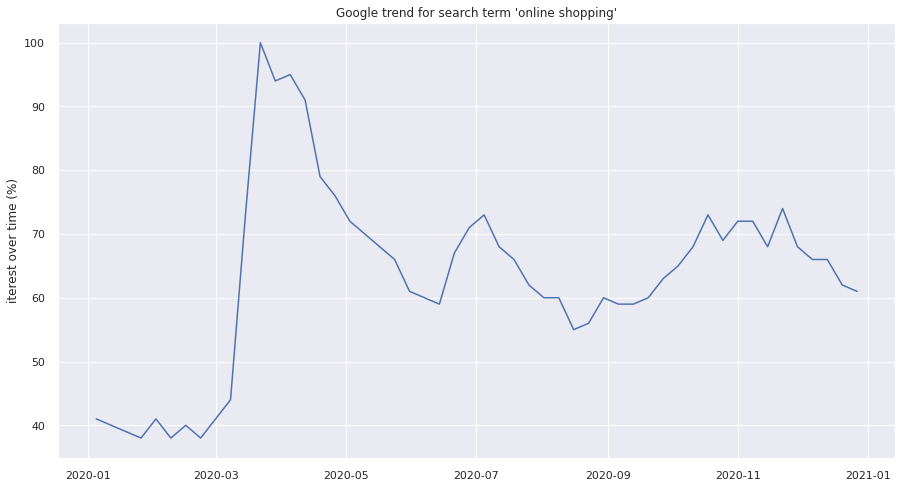

In [5]:
sns.set_theme()
fig, ax = plt.subplots(1, figsize=(15, 8))
sns.lineplot(x=df_trends.index, y=df_trends['online shopping'], ax=ax)
ax.set(ylabel='iterest over time (%)', xlabel='')
ax.title.set_text("Google trend for search term 'online shopping'")

Personal offers for customers are generated by so-called recommender systems (recsys).[Recsys](https://en.wikipedia.org/wiki/Recommender_system) is a subclass of machine learning algorithms for obtaining ranked lists of items that the user may prefer .

The whole variety of recsys can be classified into several categories:
![](https://miro.medium.com/max/2000/1*rCK9VjrPgpHUvSNYw7qcuQ@2x.png)

Within this series of publications we will be going through:
mechanics of memory-based recommender systems
building your own user-based collaborative filtering recommender
applying “out-of-box” recommenders from popular python-modules
techniques of evaluating recommenders’ efficiency and accuracy

Along that way, we will share our experience in designing so-called meta-hybrid recommender engines for real-business problem-solving.
### How does the recommender engine work?
#### Introducing data
Under the publication, we will work with the [dataset](https://grouplens.org/datasets/movielens/latest/)
In addition to users’ ratings, the dataset contains descriptive information about the movies themselves (such as year of release, genre, content tags), which we will use in the second part to improve the accuracy of the predictions of our recommender.

In [6]:
zip_path = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
dir_path = 'movielens'

In [7]:
res = requests.get(zip_path)

with zipfile.ZipFile(io.BytesIO(res.content)) as arc:
    arc.extractall(dir_path)

In [8]:
movs = pd.read_csv(os.path.join(dir_path, 'ml-latest-small', 'movies.csv'))
rats = pd.read_csv(os.path.join(dir_path, 'ml-latest-small', 'ratings.csv'))
tags = pd.read_csv(os.path.join(dir_path, 'ml-latest-small', 'tags.csv'))

In [9]:
movs.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
rats.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [11]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


To understand how a recommender works, let's create a micro-dataset in a few steps:
- randomly select several users from the main dataset
- compile a list of movies, each of which has been seen by 3 or more users from the list above
- randomly select several movies from the previous list
- from all user-movie pairs on the intersection of randomly selected users and movies construct a rating matrix.

In [12]:
rand_state, samp_size = 10, 5

rng = np.random.RandomState(rand_state)

rand_users = rng.choice(rats['userId'].unique(),
                        size=samp_size,
                        replace=False)

movs_by_rand_users = (rats[rats['userId'].isin(rand_users)]
                      .groupby('movieId')
                      .size()
                      .pipe(lambda x: x[x >= 3]))

rand_movs = rng.choice(movs_by_rand_users.index,
                       size=samp_size,
                       replace=False)

rats_tiny = (rats[(rats['userId'].isin(rand_users)) &
                  (rats['movieId'].isin(rand_movs))]
            .copy())

rats_tiny_mtx = rats_tiny.pivot(index='userId',
                                columns='movieId',
                                values='rating')

rats_tiny_mtx

movieId,253,296,318,344,434
userId,,,,,
219,3.0,4.0,5.0,4.0,3.0
242,5.0,5.0,4.0,3.0,4.0
278,NaN,NaN,5.0,NaN,NaN
349,3.0,4.0,NaN,4.0,3.0


#### Designing custom recommender engine
The resulting ratings’ matrix represents a typical context for recsys performance:
some users can receive recommendations for movies from our micro-library that they have not seen before;
personal recommendations have to be "ranked" by the recommender to preserve users' embrace of unseen movies.

The minimum necessary information for solving these tasks is within the ratings’ micro-matrix itself - that is the history of the users' interactions with the seen movies (i.e. all but the ‘memory’ of our collaborative filtering recommender).

Memory-based recommenders simply predict the rating of Y-user for an unseen Z-movie based on ratings assigned to that very Z- movie by another {A...X}-set of users, whose movie preferences are similar to those of Y-user.

In the simplest case, the rating’s prediction for the Y-Z pair is calculated as the weighted average of a set of available ratings of Z-movie subject to degrees of "similarity" of Y-user to each of the  {A...X} users.

The degree of "similarity" is the distance between ratings’ vectors of two users, standardized (scaled) by subtracting the mean. Therefore, the mean of a scaled ratings’ vector is zero, which allows us to safely fill all missing values (i.e. rating for unseen movies by a particular user) with zeros.

In [13]:
users_vecs_scaled = np.nan_to_num(
    scale(rats_tiny_mtx.to_numpy(),
          axis=1,
          with_std=False))

# replace all-zero-vecs with set of random
# infinitely small values with zero variance 
for i in np.where(~users_vecs_scaled.any(axis=1))[0]:
    users_vecs_scaled[i] = np.random.RandomState(i).normal(
        loc=0,
        scale=0.1,
        size=users_vecs_scaled.shape[1]) / np.iinfo(np.int64).max
    
users_vecs_scaled

array([[-8.00000000e-01,  2.00000000e-01,  1.20000000e+00,
         2.00000000e-01, -8.00000000e-01],
       [ 8.00000000e-01,  8.00000000e-01, -2.00000000e-01,
        -1.20000000e+00, -2.00000000e-01],
       [-4.51849764e-21, -6.10046163e-22, -2.31606845e-20,
         1.77838517e-20, -1.94444676e-20],
       [-5.00000000e-01,  5.00000000e-01,  0.00000000e+00,
         5.00000000e-01, -5.00000000e-01]])

A matrix of cosine distances between the standardized vectors of user ratings.

In [14]:
users_dists_mtx = (scipy.spatial.distance
                   .cdist(users_vecs_scaled,
                          users_vecs_scaled,
                          'cosine'))
users_dists_mtx

array([[1.11022302e-16, 1.28571429e+00, 1.08763330e+00, 4.02385695e-01],
       [1.28571429e+00, 1.11022302e-16, 1.28586301e+00, 1.29880715e+00],
       [1.08763330e+00, 1.28586301e+00, 0.00000000e+00, 4.18600652e-01],
       [4.02385695e-01, 1.29880715e+00, 4.18600652e-01, 0.00000000e+00]])

As expected, all elements of the matrix main diagonal are equal to zero (the distance from the user to himself).

After removing the main diagonal we’ll get for each user a vector of distances from him to all other users in the system. Further within the recommender engine, these distances will be converted to "inverse" weights to calculate ratings as weighted averages.

In [15]:
users_dists_mtx_no_diagonal = (users_dists_mtx[~np.eye(
    users_dists_mtx.shape[0], dtype=bool)]
    .reshape(users_dists_mtx.shape[0], -1))

users_dists_mtx_no_diagonal

array([[1.28571429, 1.0876333 , 0.4023857 ],
       [1.28571429, 1.28586301, 1.29880715],
       [1.0876333 , 1.28586301, 0.41860065],
       [0.4023857 , 1.29880715, 0.41860065]])


In other words, our custom recommender iteratively predicts ratings for each user-movie pair (including user-unseen-movie! pairs)  as a product of the vector of available ratings of a particular movie and the vector of weights inversely proportional to distances from a particular user to other users whose ratings are considered.

In [16]:
rats_tiny_arr = rats_tiny_mtx.to_numpy()


def to_weights(dist_vec):
    # zero cosine distance means equality among users
    # replace with infinitely small value to assign bigger 'reverse' weight
    rv = [1 / np.finfo(np.float64).eps if x == 0 else 1 / x for x in dist_vec]
    sm = sum(rv)
    return np.array([x / sm for x in rv])


rates_est = np.array([])

for i in range(len(rats_tiny_arr)):

    rats_tiny_arr_no_cur_user = np.delete(rats_tiny_arr, i, axis=0)

    for cur_mov_rates_by_knn in rats_tiny_arr_no_cur_user.T:

        # skip cases with no actual ratings
        notna_idx = set(np.argwhere(~np.isnan(cur_mov_rates_by_knn)).flat)
        
        cur_user_dists_to_knn = users_dists_mtx_no_diagonal[i]

        # skip cases with negative cosine distances between users,
        # meaning opposite direction of their scales rates' vectors
        notneg_idx = set(np.argwhere(cur_user_dists_to_knn > 0).flat)

        knn_idx = list(notna_idx.intersection(notneg_idx))

        user_mov_rate_est = np.dot(
            cur_mov_rates_by_knn[knn_idx],
            to_weights(cur_user_dists_to_knn[knn_idx]))

        rates_est = np.append(rates_est, user_mov_rate_est)

rates_test_idx = np.argwhere(~np.isnan(rats_tiny_arr.flat))

custom_mape = mean_absolute_percentage_error(
    rats_tiny_arr.flat[rates_test_idx].ravel(),
    rates_est[rates_test_idx])

print('Biased MAPE for custom Recommender: {:.1%}'.format(custom_mape))

Biased MAPE for custom Recommender: 15.5%


Despite its simplicity, our custom recommender handles cases of absence of actual users’ ratings (i.e. missing cells in ratings’ matrix) as well as cases of  ‘opposite’ movie-preferences of users (i.e. bidirectional scaled ratings’ vectors).

The mean absolute percentage error (MAPE) of our custom recommender is about  15.5%

### Production-ready recommenders 
We have built a recommender that predicts ratings and can produce a ranked list of recommendations - that’s so great, wow!
However, our recommender ‘as-is’ has quite a few shortcomings:
it does not allow to switch from user-based to item-based collaborative filtering
It does not allow fine-tuning the number of users to consider while calculating vectors’ product
It is not adaptable for experiments with advanced prediction algorithms
at last, it needs optimization to work with large datasets.

All these drawbacks are irrelevant to recommenders built with such a python module as a [surprise](https://surprise.readthedocs.io/en/stable/index.html)

For instance, applying to the same very ratings’ micro-matrix  "out-of-box" recommender with a slightly more advanced (but generally close to the one described above) prediction algorithm from a surprise family  (namely [KNNWithMeans](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNWithMeans)) you will immediately reduce MAPE from 15.5% to 11.4%:


In [17]:
tiny_data = (Dataset
             .load_from_df(
                 rats_tiny[['userId', 'movieId', 'rating']],
                 Reader(rating_scale=(1, 5))))

tiny_trainset = tiny_data.build_full_trainset()
tiny_testset = tiny_trainset.build_testset()
tiny_anti_testset = tiny_trainset.build_anti_testset()

algo = KNNWithMeans(sim_options={'name': 'cosine'}, verbose=False)

algo.fit(tiny_trainset)

tiny_estimations = algo.test(tiny_testset)

all_users_est_true = defaultdict(list)

for userId, movId, r_true, r_est, _ in tiny_estimations:
    all_users_est_true[(userId, movId)].extend((r_true, r_est))

r_true, r_est = zip(*all_users_est_true)

module_mape = mean_absolute_percentage_error(*zip(*list(
    all_users_est_true.values())))

print('Biased MAPE for Surprise-module Recommender: {:.1%}'.format(module_mape))

Biased MAPE for Surprise-module Recommender: 11.4%


The resulting predictions of two demo recommenders are on the visualization:

In [18]:
mlt_idx = pd.MultiIndex.from_product(
    [rats_tiny_mtx.index,
     rats_tiny_mtx.columns])

In [19]:
custom_rec = pd.DataFrame(rates_est,
                          index=mlt_idx,
                         columns=['rating'])

In [20]:
tiny_predictions = algo.test(tiny_anti_testset)

for userId, movId, r_true, r_est, _ in tiny_predictions:
    all_users_est_true[(userId, movId)].extend((r_true, r_est))

module_rec = (pd.Series({k: v[1]
                        for k, v in all_users_est_true.items()})
              .to_frame(name='rating'))

module_rec = module_rec.reindex(mlt_idx)

In [21]:
txt_1_1 = """Initial matrix:
true rates for known
user-movie pairs
(to find similar users)"""

txt_2_1 = """Custom Recommender:
est. rates for known
user-movie pairs
(biased MAPE = {:.1%})""".format(custom_mape)

txt_3_1 = """Module Recommender:
est. rates for known
user-movie pairs
(biased MAPE = {:.1%})""".format(module_mape)

txt_1_2 = ''

txt_2_2 = """Custom Recommender:
est. rates for unknown
user-movie pairs
(to recommend or not)"""

txt_3_2 = """Module Recommender:
est. rates for unknown
user-movie pairs
(to recommend or not)"""


rats_tiny['type'] = txt_1_1
rats_tiny['mask'] = 1
rats_tiny.loc[rats_tiny['rating'].notna(), 'mask'] = 0

custom_rec['type'] = txt_2_1
custom_rec['mask'] = 1
custom_rec.iloc[rates_test_idx.ravel(),
                custom_rec.columns.get_loc('mask')] = 0

module_rec['type'] = txt_3_1
module_rec['mask'] = 1
module_rec.iloc[rates_test_idx.ravel(),
                module_rec.columns.get_loc('mask')] = 0

data_viz = (pd.concat([rats_tiny.set_index(['userId', 'movieId'])[['rating', 'type', 'mask']],
                      custom_rec, 
                      module_rec])
            .reset_index())

data_viz_copy = data_viz.copy()

data_viz_copy['type'] = data_viz_copy['type'].replace(
    {txt_1_1: txt_1_2,
     txt_2_1: txt_2_2,
     txt_3_1: txt_3_2})

data_viz_copy['mask'] = abs(data_viz_copy['mask'] - 1)

data_viz = pd.concat([data_viz, data_viz_copy])

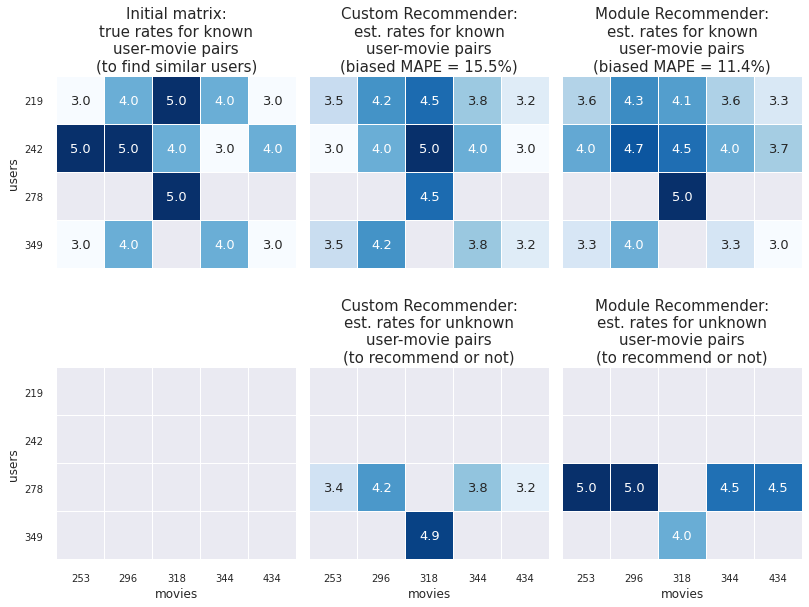

In [22]:
vmin, vmax = data_viz['rating'].agg(['min', 'max'])


def draw_heatmap(*args, **kwargs):

    d_raw = kwargs.pop('data')

    d_pvt = d_raw.pivot(index=args[0], columns=args[1], values=args[2])
    d_msk = (d_raw.pivot(index=args[0],
                         columns=args[1],
                         values=args[3])
             .astype(bool))

    sns.heatmap(d_pvt,
                annot=True,
                annot_kws={'fontsize': 13},
                fmt='.1f',
                vmin=vmin,
                vmax=vmax,
                cbar=False,
                mask=d_msk,
                **kwargs)


fg = sns.FacetGrid(data_viz,
                   col='type',
                   col_wrap=3,
                   height=4.75,
                   aspect=0.8)

# https://docs.python.org/3/library/warnings.html#temporarily-suppressing-warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fg.map_dataframe(draw_heatmap,
                     'userId',
                     'movieId',
                     'rating',
                     'mask',
                     cmap="Blues",
                     square=True,
                     linewidth=0.1)

for i, ax in enumerate(fg.axes.flat):
    ax.set_aspect('equal', 'box')
    if i in range(3, 6):
        ax.set_xlabel('movies')
    if i in [0, 3]:
        ax.set_ylabel('users')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)

fg.set_titles(col_template='{col_name}',  size=15)
fg.fig.tight_layout()

### Valuable recommendation: be careful with the evaluation of recommenders
We usually do not use MAPE / MAE / RMSE to compare the accuracy of recommenders, but rather precision and recall for lists of items with estimated ratings above a specified threshold.

Note from the visualisation above how recommendations for the same users will change if we decide to set the minimum rating for a movie to be recommended within our movies micro-library to be 3.5 or 4.0?

We will show how to use proper metrics and improve the efficiency of the "out-of-box" SVD prediction algorithm (from the surprise module) known as the Netflix-prize winner (https://pantelis.github.io/cs301/docs/common/lectures/recommenders/netflix/ ) in the next part of this publication.

## Building memory-efficient meta-hybrid recommender engine: back to front (part 2)
(...comments and text to be added afterwards...)

In [23]:
movs_genre_dct = {}

for idx, row in movs.iterrows():
    movs_genre_dct[row['movieId']] = row['genres'].split('|')

movs_genre_dfr = (pd.DataFrame
                  .from_dict(movs_genre_dct, orient='index')
                  .stack()
                  .to_frame()
                  .reset_index()
                  .drop('level_1', axis=1)
                  .rename(columns={'level_0': 'movieId',
                                   0: 'genre'})
                  .assign(values=1)
                  .pivot_table(values='values',
                               index='movieId',
                               columns='genre',
                               fill_value=0,
                               dropna=False)
                  .reset_index())

movs_genre_dfr.head()

genre,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
movs['year'] = movs['title'].str.extract(r'\(.*(\d{4})\)')

In [25]:
tags_dct = defaultdict(set)

for idx, row in tags.iterrows():
    tags_dct[row['movieId']].add(row['tag'])

tags_dct = {k: ' '.join(v) for k, v in tags_dct.items()}

tags_dfr = (pd.DataFrame
            .from_dict(tags_dct, orient='index')
            .reset_index()
            .rename(columns={'index': 'movieId',
                             0: 'tags'}))

tags_dfr.head()

,movieId,tags
0,60756,comedy Highly quotable will ferrell funny
1,89774,Tom Hardy Boxing story MMA
2,106782,Leonardo DiCaprio Martin Scorsese drugs Wall S...
3,48516,Leonardo DiCaprio Martin Scorsese atmospheric ...
4,431,Al Pacino gangster mafia


In [26]:
movs_data = reduce(lambda left, right:
                   pd.merge(left,
                            right,
                            how='outer',
                            on='movieId',
                            copy=False),
                   [movs, movs_genre_dfr, tags_dfr])

movs_data['title_tags'] = movs_data['title'].str.cat(movs_data['tags'],
                                                     sep=' ',
                                                     na_rep='')

In [27]:
movs_data = (movs_data
             .drop(['title',
                    'genres',
                   'tags'],
                   axis=1)
             .set_index('movieId'))

movs_data.fillna(movs_data.mode().iloc[0], inplace=True)

In [28]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.ref_dic = None

    @staticmethod
    def _get_enc(ser):
        count = ser.value_counts()
        noise = abs(np.random.normal(5e-6, 1e-5, len(count)))
        return (count / count.sum() + noise).to_dict()

    def fit(self, X, y=None):
        self.ref_dic = {}
        for col in self.cols:
            col_enc = self._get_enc(X[col])
            self.ref_dic[col] = col_enc
        return self

    def transform(self, X, y=None):
        for col in self.cols:
            X[col] = X[col].apply(
                lambda x, col=col: self.ref_dic[col].get(x, 0))
        return X

In [29]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text


class StemmedTfidfVectorizer(TfidfVectorizer):

    english_stemmer = nltk.stem.SnowballStemmer('english')

    def build_analyzer(self):
        analyzer = TfidfVectorizer.build_analyzer(self)
        return lambda doc: (self.english_stemmer.stem(w)
                            for w in analyzer(doc))

In [30]:
data_pipe = make_pipeline(
    FrequencyEncoder(['year']),
    make_column_transformer(
        (StemmedTfidfVectorizer(stop_words='english',
                                preprocessor=preprocess_text,
                                decode_error='ignore',
                                max_features=500),
         'title_tags'),
        remainder='passthrough'),
    TruncatedSVD(n_components=50,
                 random_state=rand_state))

movs_data_enc = data_pipe.fit_transform(movs_data)

movs_data_enc.shape

(9742, 50)

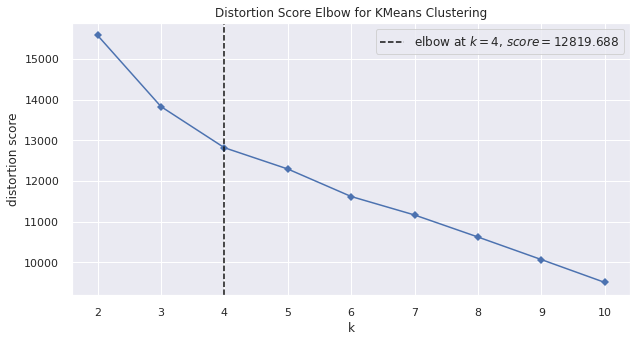

In [31]:
model = KMeans(random_state=rand_state)

fig, ax = plt.subplots(1, figsize=(10, 5))

visualizer = KElbowVisualizer(model,
                              k=10,
                              timings=False,
                             ax=ax)
visualizer.fit(movs_data_enc)

visualizer.show()

In [32]:
model_tuned = KMeans(visualizer.elbow_value_, random_state=rand_state)

model_tuned.fit(movs_data_enc)

movs_data['cluster'] = model_tuned.labels_

movs_data.groupby('cluster').size()

cluster_dct = dict(zip(movs_data.index, model_tuned.labels_))

rats['cluster'] = rats['movieId'].map(lambda x: cluster_dct[x])

rats.groupby('cluster').size().rename('num. of records')

cluster
0    25862
1    15312
2    27985
3    31677
Name: num. of records, dtype: int64

In [33]:
data = (Dataset
        .load_from_df(rats[['userId', 'movieId', 'rating']], Reader()))

raw_ratings = data.raw_ratings

kf = KFold(n_splits=3, shuffle=True, random_state=rand_state)

algo = SVD(random_state=rand_state)

In [34]:
# https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-compute-precision-k-and-recall-k
def precision_recall_at_k(predictions, k=5, threshold=4):
    
    user_est_true = defaultdict(list)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    prec = dict()
    recs = dict()

    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        prec[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        recs[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return prec, recs

In [35]:
res_metrics = []
Res = namedtuple('Res', ['fold', 'case', 'time', 'mem'])


# https://hakibenita.com/fast-load-data-python-postgresql
def profile(fn):

    @wraps(fn)
    def inner(*args, **kwargs):

        fold = kwargs.pop('fold')
        case = kwargs.pop('case')

        tm = time.perf_counter()
        retval = fn(*args, **kwargs)
        elapsed = time.perf_counter() - tm

        mem, retval = memory_usage(
            (fn, args, kwargs), retval=True, timeout=200, interval=1e-7)

        res_metrics.append(Res(fold, case, elapsed, max(mem) - min(mem)))
        return retval

    return inner

In [36]:
@profile
def get_predictions(trn_index, tst_index, alg=algo):

    A_raw_ratings = [raw_ratings[i] for i in trn_index]
    B_raw_ratings = [raw_ratings[i] for i in tst_index]

    data.raw_ratings = A_raw_ratings

    trainset = data.build_full_trainset()
    testset = data.construct_testset(B_raw_ratings)

    alg.fit(trainset)

    return alg.test(testset)

In [37]:
folds_metrics_data = []

for i, (train_index, test_index) in enumerate(kf.split(raw_ratings), 1):

    no_cl_predictions = get_predictions(train_index,
                                        test_index,
                                        fold=i,
                                        case='raw items')

    cl_predictions = []

    for cl in rats['cluster'].unique():

        cl_index = []
        for idx in [train_index, test_index]:
            cl_index.append(rats
                            .iloc[idx]
                            .pipe(lambda x, cl=cl:
                                  x[x['cluster'] == cl].index))

        cl_predictions.extend(get_predictions(*cl_index,
                                              fold=i,
                                              case='clustered'))

    for key, val in dict(zip(
            ['raw items', 'clustered'],
            [no_cl_predictions, cl_predictions])).items():

        precisions, recalls = precision_recall_at_k(val)

        folds_metrics_data.append(pd.concat(
            [pd.Series(precisions,
                       name="""SVD recommender's precision at k=5
(distribution and average over all users)"""),
             pd.Series(recalls,
                       name="""SVD recommender's recall at k=5
(distribution and average over all users)""")],
            axis=1)
            .assign(fold='fold #{}'.format(i))
            .assign(case=key))

In [38]:
folds_metrics_viz = (pd.concat(folds_metrics_data, ignore_index=True)
                     .melt(id_vars=['fold', 'case']))

row, col, hue = ('fold', 'variable', 'case')
means = (np.asarray(folds_metrics_viz
                    .groupby([row, col, hue])['value']
                    .mean())
         .reshape(-1, 2))

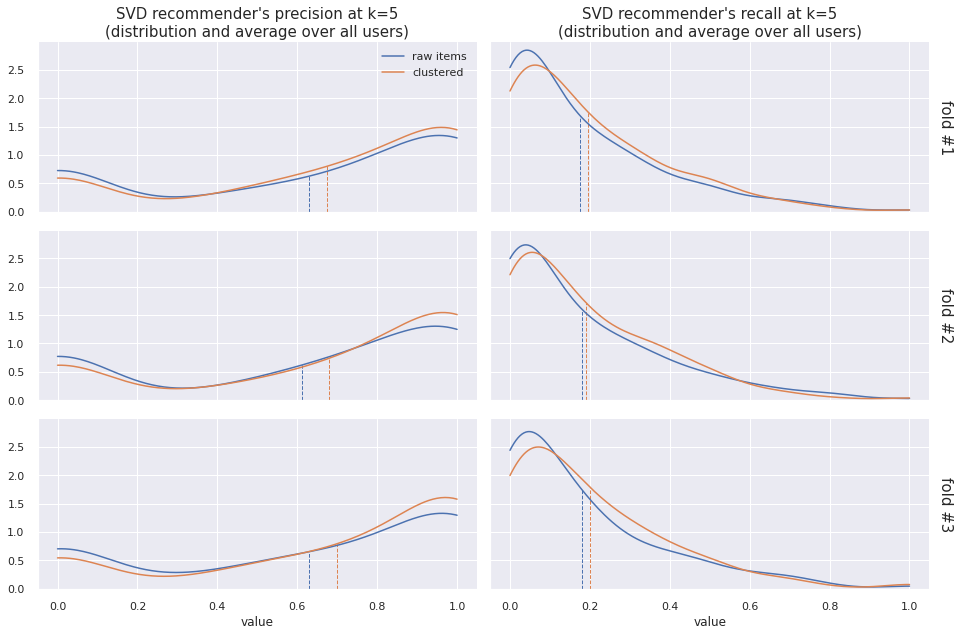

In [39]:
fg = sns.FacetGrid(data=folds_metrics_viz,
                   row=row,
                   col=col,
                   hue=hue,
                   margin_titles=True,
                   height=3,
                   aspect=2.25)

fg.map(sns.kdeplot,
       'value',
       clip=(0, 1),
       bw_adjust=1.25,
       linewidth=1.5)


for i, ax in enumerate(fg.axes.flat):

    if i == 0:
        ax.legend()

    # https://stackoverflow.com/questions/28956622/how-to-locate-the-median-in-a-seaborn-kde-plot
    for j, line in enumerate(ax.get_lines()):

        x, y = line.get_data()

        nearest_to_mean = np.abs(x - np.flip(means[i])[j]).argmin()
        x_mean = x[nearest_to_mean]
        y_mean = y[nearest_to_mean]

        ax.vlines(x=x_mean,
                  ymin=0,
                  ymax=y_mean,
                  linestyles='--',
                  colors=line.get_color(),
                  linewidth=1)

fg.set_titles(col_template='{col_name}',
              row_template='{row_name}',
              size=15)
fg.fig.tight_layout()

In [40]:
compare_res_metrics = (pd.DataFrame(res_metrics)
                       .groupby(['fold', 'case'])
                       .agg({'time': 'sum', 'mem': 'max'})
                       .groupby(level='case')
                       .mean())

compare_res_metrics

,time,mem
case,,
clustered,4.313436,4.28776
raw items,4.350161,18.93750
